In [1]:
!mkdir data

���� ���͸� �Ǵ� ���� data��(��) �̹� �ֽ��ϴ�.


In [2]:
cd/style

d:\style


In [113]:
from PIL import Image
path2content = 'D:\\style\\data\\dog.jpg'
path2style = 'D:\\style\\data\\gi.jpg'

content_img = Image.open(path2content)
style_img = Image.open(path2style)

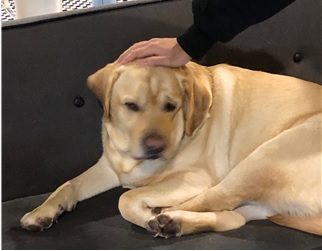

In [114]:
content_img
# print(content_img) #1334

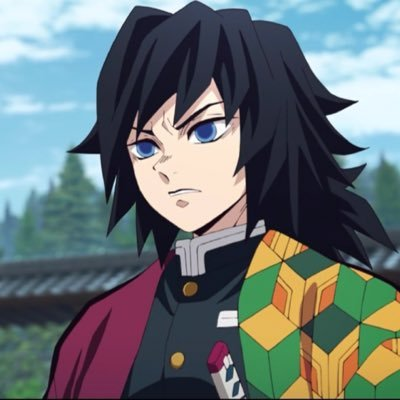

In [115]:
style_img

In [116]:
import torchvision.transforms as transforms

h, w = 256, 384
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)

transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean_rgb, std_rgb)
])

In [117]:
content_tensor = transformer(content_img)
style_tensor = transformer(style_img)
print(content_tensor.shape, content_tensor.requires_grad)
print(style_tensor.shape, style_tensor.requires_grad)

torch.Size([3, 256, 384]) False
torch.Size([3, 256, 384]) False


In [118]:
import torch

def imgtensor2pil(img_tensor):
    img_tensor_c = img_tensor.clone().detach()
    img_tensor_c *= torch.tensor(std_rgb).view(3, 1,1)
    img_tensor_c += torch.tensor(mean_rgb).view(3,1,1)
    img_tensor_c = img_tensor_c.clamp(0,1)
    img_pil = to_pil_image(img_tensor_c)
    return img_pil

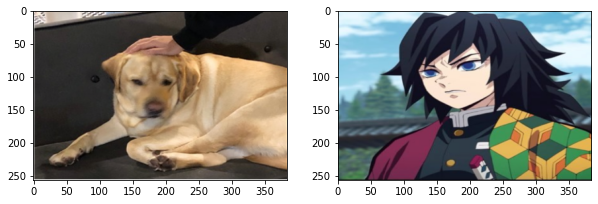

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.transforms.functional import to_pil_image

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(imgtensor2pil(content_tensor))
plt.subplot(1,2,2)
plt.imshow(imgtensor2pil(style_tensor))

In [120]:
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vgg = models.vgg19(pretrained=True).features.to(device).eval()

# 파라미터를 freeze 합니다.
for param in model_vgg.parameters():
    param.requires_grad_(False)

In [121]:
def get_features(x, model, layers):
    features = {}
    for name, layer in enumerate(model.children()): # 0, conv
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features

In [122]:
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n*c, h*w)
    gram = torch.mm(x,x.t()) # 행렬간 곱셈 수행
    return gram

In [123]:
import torch.nn.functional as F

def get_content_loss(pred_features, target_features, layer):
    target = target_features[layer]
    pred = pred_features[layer]
    loss = F.mse_loss(pred, target)
    return loss

In [124]:
def get_style_loss(pred_features, target_features, style_layers_dict):
    loss = 0
    for layer in style_layers_dict:
        pred_fea = pred_features[layer]
        pred_gram = gram_matrix(pred_fea)
        n, c, h, w = pred_fea.shape
        target_gram = gram_matrix(target_features[layer])
        layer_loss = style_layers_dict[layer] * F.mse_loss(pred_gram, target_gram)
        loss += layer_loss / (n*c*h*w)
    return loss

In [125]:
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}

con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)

content_features = get_features(con_tensor, model_vgg, feature_layers)
style_features = get_features(sty_tensor, model_vgg, feature_layers)

In [126]:
for key in content_features.keys():
    print(content_features[key].shape)

torch.Size([1, 64, 256, 384])
torch.Size([1, 128, 128, 192])
torch.Size([1, 256, 64, 96])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 16, 24])


In [127]:
input_tensor = con_tensor.clone().requires_grad_(True)

# optimizer를 정의합니다.
from torch import optim
optimizer = optim.Adam([input_tensor], lr=0.01)

In [128]:
num_epochs = 500
content_weight = 1e0
style_weight = 1e5
content_layer = 'conv5_1'
style_layers_dict = {'conv1_1':0.75,
                     'conv2_1':0.5,
                     'conv3_1':0.25,
                     'conv4_1':0.25,
                     'conv5_1':0.25}

In [135]:
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    input_features = get_features(input_tensor, model_vgg, feature_layers) # feature_layers에 해당하는 layer의 출력값 얻기
    content_loss = get_content_loss(input_features, content_features, content_layer) # 
    style_loss = get_style_loss(input_features, style_features, style_layers_dict)
    neural_loss = content_weight * content_loss + style_weight * style_loss
    neural_loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % 100 == 0:
        print('epoch {}, content loss: {:.2}, style loss: {:.2}'.format(epoch, content_loss, style_loss))

epoch 0, content loss: 4.6, style loss: 0.57
epoch 100, content loss: 4.7, style loss: 0.54
epoch 200, content loss: 4.7, style loss: 0.52
epoch 300, content loss: 4.7, style loss: 0.5
epoch 400, content loss: 4.7, style loss: 0.48
epoch 500, content loss: 4.7, style loss: 0.46


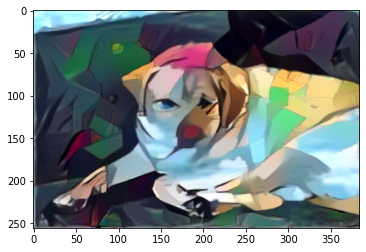

In [136]:
plt.imshow(imgtensor2pil(input_tensor[0].cpu()))